In [1]:
import os
import pandas as pd
import numpy as np
from time import time
from datetime import datetime, timedelta
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, concatenate, Flatten, Dense, Dropout
from keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import keras
import tensorflow as tf

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Column headers for the dataset
data_cols = ['user id', 'movie id', 'rating', 'timestamp']
item_cols = ['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action',
             'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
             'Horror', 'Musical', 'Mystery', 'Romance ', 'Sci-Fi', 'Thriller', 'War', 'Western']
user_cols = ['user id', 'age', 'gender', 'occupation', 'zip code']

# Importing the data files into dataframes
users = pd.read_csv('/content/drive/MyDrive/ml-100k/u.user', sep='|', names=user_cols, encoding='latin-1')
item = pd.read_csv('/content/drive/MyDrive/ml-100k/u.item', sep='|', names=item_cols, encoding='latin-1')
data = pd.read_csv('/content/drive/MyDrive/ml-100k/u.data', sep='\t', names=data_cols, encoding='latin-1')

# Create a merged dataframe
df = pd.merge(pd.merge(item, data), users)

In [4]:
df_wide = df[['gender', 'occupation']]
df_wide['gender_occupation'] = df_wide['gender'] + "_" + df_wide['occupation']
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(df_wide[['gender_occupation']])
one_hot_encoded_df = pd.DataFrame(encoder.transform(df_wide[['gender_occupation']]).toarray(),
                                  columns=encoder.get_feature_names())
df_wide = df_wide.join(one_hot_encoded_df)
df_wide.drop(['gender', 'occupation', 'gender_occupation'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [5]:
df_deep = df[['age', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary',
              'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance ', 'Sci-Fi', 'Thriller', 'War',
              'Western', 'gender', 'occupation']]
# Combine sparse categorical features into one single genre feature
df_deep['genre'] = df_deep[['unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary',
                            'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance ', 'Sci-Fi',
                            'Thriller', 'War', 'Western']].idxmax(1)
df_deep.drop(columns=['unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary',
                      'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance ', 'Sci-Fi', 'Thriller',
                      'War', 'Western'], axis=1, inplace=True)

# Encode categorical features
for feature in ['gender', 'occupation', 'genre']:
    encoder = LabelEncoder()
    encoder.fit(df_deep[[feature]])
    transformed_feature = encoder.transform(df_deep[[feature]])
    df_deep[feature] = transformed_feature

# Min-max scaling for numerical features
for feature in ['age']:
    scaler = MinMaxScaler()
    scaler.fit(df_deep[[feature]])
    transformed_feature = scaler.transform(df_deep[[feature]])
    df_deep[feature] = transformed_feature

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocess

In [6]:
# Split data
X = pd.concat([df_wide, df_deep], axis=1)
y = df[['rating']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def prepare_independent_variables(X):
    """Split X dataframe into its separate input components for the neural network
    """
    wide_inputs = X[['x0_F_administrator', 'x0_F_artist', 'x0_F_educator', 'x0_F_engineer',
                     'x0_F_entertainment', 'x0_F_executive', 'x0_F_healthcare',
                     'x0_F_homemaker', 'x0_F_lawyer', 'x0_F_librarian', 'x0_F_marketing',
                     'x0_F_none', 'x0_F_other', 'x0_F_programmer', 'x0_F_retired',
                     'x0_F_salesman', 'x0_F_scientist', 'x0_F_student', 'x0_F_technician',
                     'x0_F_writer', 'x0_M_administrator', 'x0_M_artist', 'x0_M_doctor',
                     'x0_M_educator', 'x0_M_engineer', 'x0_M_entertainment',
                     'x0_M_executive', 'x0_M_healthcare', 'x0_M_homemaker', 'x0_M_lawyer',
                     'x0_M_librarian', 'x0_M_marketing', 'x0_M_none', 'x0_M_other',
                     'x0_M_programmer', 'x0_M_retired', 'x0_M_salesman', 'x0_M_scientist',
                     'x0_M_student', 'x0_M_technician', 'x0_M_writer']].values
    categorical_input_1 = X[['gender']].values
    categorical_input_2 = X[['occupation']].values
    categorical_input_3 = X[['genre']].values
    numerical_input = X[['age']].values
    return wide_inputs, categorical_input_1, categorical_input_2, categorical_input_3, \
           numerical_input

wide_inputs_train, categorical_input_1_train, categorical_input_2_train, \
categorical_input_3_train, numerical_input_train = prepare_independent_variables(X_train)

wide_inputs_test, categorical_input_1_test, categorical_input_2_test, \
categorical_input_3_test, numerical_input_test = prepare_independent_variables(X_test)

y_train = y_train.values
y_test = y_test.values

In [7]:
# Define our deep network with the Functional API
max_num_categorical_values = 50
emb_dimension = 64
max_sequence_length = 1

categorical_input_1 = Input(shape=(1,), name='categorical_input_1')
emb_1 = Embedding(input_dim=max_num_categorical_values, output_dim=emb_dimension,
                  input_length=max_sequence_length, name='emb_1')(categorical_input_1)
emb_1 = Flatten()(emb_1)
categorical_input_2 = Input(shape=(1,), name='categorical_input_2')
emb_2 = Embedding(input_dim=max_num_categorical_values, output_dim=emb_dimension,
                  input_length=max_sequence_length, name='emb_2')(categorical_input_2)
emb_2 = Flatten()(emb_2)
categorical_input_3 = Input(shape=(1,), name='categorical_input_3')
emb_3 = Embedding(input_dim=max_num_categorical_values, output_dim=emb_dimension,
                  input_length=max_sequence_length, name='emb_3')(categorical_input_3)
emb_3 = Flatten()(emb_3)
numerical_input = Input(shape=(1,), name='numerical_input')
concatenated_embeddings = concatenate([emb_1, emb_2, emb_3, numerical_input])
concatenated_embeddings = Dropout(rate=0.2)(concatenated_embeddings)
x1 = Dense(64, activation='relu')(concatenated_embeddings)
# x1 = Dropout(rate=0.2)(x1)
x2 = Dense(64, activation='relu')(x1)
# x2 = Dropout(rate=0.2)(x2)
x3 = Dense(64, activation='relu')(x2)
# x3 = Dropout(rate=0.2)(x3)
x4 = Dense(64, activation='relu')(concatenate([x1, x3]))
# x4 = Dropout(rate=0.2)(x4)
x5 = Dense(64, activation='relu')(x4)
# x5 = Dropout(rate=0.2)(x5)
x6 = Dense(64, activation='relu')(x5)
# x6 = Dropout(rate=0.2)(x6)
x7 = Dense(64, activation='relu')(concatenate([x4, x6]))
# x7 = Dropout(rate=0.2)(x7)
x8 = Dense(64, activation='relu')(x7)
# x8 = Dropout(rate=0.2)(x8)
x9 = Dense(64, activation='relu')(x8)
# x9 = Dropout(rate=0.2)(x9)
deep_output = Dense(64, activation='relu')(x9)

In [8]:
# Define our wide network with the Functional API
num_features = len(df_wide.columns)
wide_inputs = Input(shape=(num_features,), name='wide_inputs')

In [9]:
# Combine wide and deep into one model
x = concatenate([wide_inputs, deep_output])
x = Dropout(rate=0.2)(x)
wide_and_deep_output = Dense(1, activation='relu')(x)
wide_and_deep_model = Model(inputs=[wide_inputs] + [categorical_input_1] + 
                            [categorical_input_2] + [categorical_input_3] + 
                            [numerical_input], outputs=wide_and_deep_output)
wide_and_deep_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 categorical_input_1 (InputLaye  [(None, 1)]         0           []                               
 r)                                                                                               
                                                                                                  
 categorical_input_2 (InputLaye  [(None, 1)]         0           []                               
 r)                                                                                               
                                                                                                  
 categorical_input_3 (InputLaye  [(None, 1)]         0           []                               
 r)                                                                                           

In [10]:
wide_and_deep_model.compile(loss='mse', optimizer='adam', metrics=['mse'])


In [11]:
date_time = (datetime.utcnow() + timedelta(hours=8)).strftime('[%Y-%m-%d %H-%M-%S]')
tensorboard = TensorBoard(log_dir='./logs/tensorboard/{}'.format(date_time))
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/ml-100k/wide_and_deep_model.h5',
                                   monitor='val_loss',
                                   save_weights_only=True,
                                   save_best_only=True)
callbacks = [model_checkpoint, early_stopping, tensorboard]

wide_and_deep_model.fit(x={'wide_inputs': wide_inputs_train,
                           'categorical_input_1': categorical_input_1_train,
                           'categorical_input_2': categorical_input_2_train,
                           'categorical_input_3': categorical_input_3_train,
                           'numerical_input': numerical_input_train},
                        y=y_train,
                        batch_size=32, epochs=10, verbose=1,
                        callbacks=callbacks, validation_split=0.2)

Epoch 1/10
2000/2000 [==============================] - 28s 12ms/step - loss: 1.4514 - mse: 1.4514 - val_loss: 1.2210 - val_mse: 1.2210
Epoch 2/10
2000/2000 [==============================] - 11s 5ms/step - loss: 1.3207 - mse: 1.3207 - val_loss: 1.2284 - val_mse: 1.2284
Epoch 3/10
2000/2000 [==============================] - 12s 6ms/step - loss: 1.2958 - mse: 1.2958 - val_loss: 1.2345 - val_mse: 1.2345
Epoch 4/10
2000/2000 [==============================] - 10s 5ms/step - loss: 1.2759 - mse: 1.2759 - val_loss: 1.2355 - val_mse: 1.2355
Epoch 5/10
2000/2000 [==============================] - 11s 6ms/step - loss: 1.2689 - mse: 1.2689 - val_loss: 1.2136 - val_mse: 1.2136
Epoch 6/10
2000/2000 [==============================] - 11s 6ms/step - loss: 1.2601 - mse: 1.2601 - val_loss: 1.2209 - val_mse: 1.2209
Epoch 7/10
2000/2000 [==============================] - 11s 6ms/step - loss: 1.2482 - mse: 1.2482 - val_loss: 1.2258 - val_mse: 1.2258
Epoch 8/10
2000/2000 [==============================] 

In [12]:
wide_and_deep_model.evaluate(x={'wide_inputs': wide_inputs_test,
                                'categorical_input_1': categorical_input_1_test,
                                'categorical_input_2': categorical_input_2_test,
                                'categorical_input_3': categorical_input_3_test,
                                'numerical_input': numerical_input_test},
                             y=y_test,
                             batch_size=32, verbose=1)

625/625 [==============================] - 2s 3ms/step - loss: 1.2074 - mse: 1.2074


[1.2074278593063354, 1.2074278593063354]

In [13]:
predictions = wide_and_deep_model.predict(x={'wide_inputs': wide_inputs_test,
                                             'categorical_input_1': categorical_input_1_test,
                                             'categorical_input_2': categorical_input_2_test,
                                             'categorical_input_3': categorical_input_3_test,
                                             'numerical_input': numerical_input_test},
                                          batch_size=32, verbose=1)

625/625 [==============================] - 2s 2ms/step


In [14]:
predictions

array([[3.6100426],
       [3.986638 ],
       [3.324067 ],
       ...,
       [3.1929483],
       [3.6424644],
       [3.3647704]], dtype=float32)

In [15]:
classes, counts = np.unique(predictions, return_counts=True)
print(classes, counts)

[1.7551992 1.7658625 1.7787608 ... 4.057716  4.0848417 4.0915713] [2 4 4 ... 5 1 1]


[1.7551992 1.7658625 1.7787608 ... 4.057716  4.0848417 4.0915713] [2 4 4 ... 5 1 1]


<BarContainer object of 3770 artists>

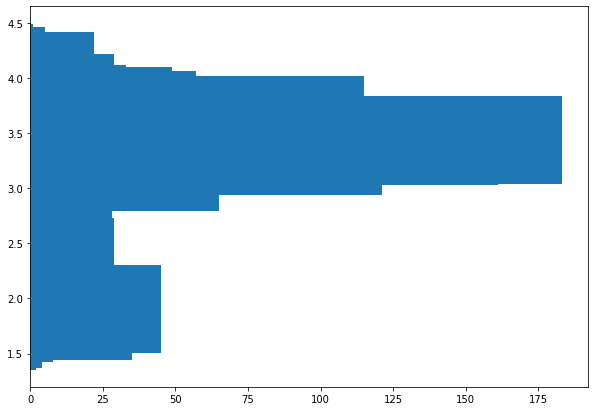

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
print(classes, counts)
plt.figure(figsize=(10,7))
# p = sns.countplot(arr.flatten())
# p.set(xticklabels = class_names)
plt.barh(classes, counts)
# plt.title('Class distribution')

In [17]:
def compute_accuracy(y_true, y_pred):
    correct_predictions = 0
    # iterate over each label and check
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    # compute the accuracy
    accuracy = correct_predictions/len(y_true)
    return accuracy

In [18]:
np.round(predictions)
int_array = np.round(predictions).astype(int)


In [19]:
print("Prediction Accuracy" , compute_accuracy(y_test, int_array))

Prediction Accuracy 0.3325
